## `분석주제`

### Import

In [1]:
import numpy as np
import pandas as pd

### Read Data

In [2]:
train = pd.read_csv('/Users/hyunji/1. DaconJeju/data/raw/train.csv')
test = pd.read_csv('/Users/hyunji/1. DaconJeju/data/raw/test.csv')

## 2. Data Cleansing

#### [Imputation] road name
'-'는 결측치이다. 출발지점과 도착지점을 정렬한 후 가까운 값으로 대치한다.

In [3]:
replace = train.sort_values(['start_latitude', 'start_longitude', 'end_latitude','end_longitude'])[['id','road_name']]
fb = replace['road_name'].apply(lambda x: np.nan if x=='-' else x).fillna(method='ffill').fillna(method='backfill')
bf = replace['road_name'].apply(lambda x: np.nan if x=='-' else x).fillna(method='backfill').fillna(method='ffill')

print('ffill 후 backfill하는 방법의 차이:', (train.query('road_name != "-"').road_name.value_counts(normalize=True)\
                                             - fb.value_counts(normalize=True)).std())
print('backfill 후 ffill하는 방법의 차이:', (train.query('road_name != "-"').road_name.value_counts(normalize=True)\
                                             - bf.value_counts(normalize=True)).std())

ffill 후 backfill하는 방법의 차이: 0.0029825077021651365
backfill 후 ffill하는 방법의 차이: 0.002328224428765971


In [4]:
train['road_name'] = bf

#### [Labeling] node name
node name을 labeling하고 이로써 출발지점, 도착지점의 방향을 고려한 labeling을 시도한다.

In [5]:
label_df = pd.concat([train['start_node_name'].rename('node_name'), train['end_node_name'].rename('node_name')]).drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'node_label'}).set_index('node_name')

for label in pd.concat([test['start_node_name'].rename('node_name'), test['end_node_name'].rename('node_name')]).drop_duplicates():
    if label not in label_df.index:
        label_df.loc[label] = label_df['node_label'].max() + 1
        
display(label_df)

,node_label
node_name,
제3교래교,0
광양사거리,1
창고천교,2
남양리조트,3
애월샷시,4
...,...
상위미,485
와산리,486
성산보건지소,487


In [6]:
train['start_node_label'] = pd.merge(train[['id','start_node_name']], 
                                     label_df.reset_index().rename(columns={'node_name':'start_node_name'}), 
                                     on='start_node_name', how='left')['node_label']
train['end_node_label'] = pd.merge(train[['id','end_node_name']], 
                                   label_df.reset_index().rename(columns={'node_name':'end_node_name'}), 
                                   on='end_node_name', how='left')['node_label']

In [7]:
test['start_node_label'] = pd.merge(test[['id','start_node_name']], 
                                     label_df.reset_index().rename(columns={'node_name':'start_node_name'}), 
                                     on='start_node_name', how='left')['node_label']
test['end_node_label'] = pd.merge(test[['id','end_node_name']], 
                                   label_df.reset_index().rename(columns={'node_name':'end_node_name'}), 
                                   on='end_node_name', how='left')['node_label']

In [8]:
# data labeling
label_df = train[['start_node_label','end_node_label']].drop_duplicates()\
           .reset_index(drop=True).reset_index().rename(columns={'index':'edge_label'}).set_index(['start_node_label','end_node_label'])
for label in test[['start_node_label','end_node_label']].drop_duplicates().values:
    if tuple(label) not in label_df.index:
        label_df.loc[tuple(label), 'edge_label'] = label_df['edge_label'].max()+1
        
label_df = label_df.reset_index()

In [9]:
#Need Minus Labeling
display(label_df.query("start_node_label==203 & end_node_label ==0"))
label_df.query("start_node_label==0 & end_node_label ==203")

,start_node_label,end_node_label,edge_label
237,203,0,237


,start_node_label,end_node_label,edge_label
762,0,203,762


In [10]:
# Minus labeling
for IDX, START, END, EDGE in label_df.itertuples():
    CHANGE = label_df.loc[IDX:].query('(start_node_label==@END) & (end_node_label==@START)').index
    if len(CHANGE)==1:
        label_df.iloc[CHANGE, -1] = -1 * EDGE

In [11]:
display(label_df.query("edge_label==237"))
label_df.query("edge_label==-237")

,start_node_label,end_node_label,edge_label
237,203,0,237


,start_node_label,end_node_label,edge_label
762,0,203,-237


In [12]:
train['edge_label'] = pd.merge(train[['id','start_node_label','end_node_label']], label_df, 
                               on=['start_node_label','end_node_label'], how='left')['edge_label']

In [13]:
test['edge_label'] = pd.merge(test[['id','start_node_label','end_node_label']], label_df, 
                               on=['start_node_label','end_node_label'], how='left')['edge_label']

#### diff data

In [14]:

positive = train.query('edge_label > 0')

negative = train.query('edge_label < 0')
negative['minus_edge_label'] = negative.edge_label
negative['edge_label'] = negative.edge_label.abs()

ease = pd.merge(positive[['id','base_date', 'base_hour', 'edge_label','target']], 
                 negative[['id','base_date', 'base_hour', 'edge_label','target']], on=['base_date', 'base_hour', 'edge_label'])

<ipython-input-14-65d763332da3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative['minus_edge_label'] = negative.edge_label
<ipython-input-14-65d763332da3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative['edge_label'] = negative.edge_label.abs()


In [15]:
#이녀석들은 시간대는 같고 출발지와 도착지만 다른데 속도가 다른애들.. 왜이런걸까???
ease.query("edge_label==237")

,id_x,base_date,base_hour,edge_label,target_x,id_y,target_y
202,TRAIN_0000292,20211224,15,237,52.0,TRAIN_1571940,48.0
336,TRAIN_0000560,20211231,16,237,52.0,TRAIN_0860201,40.0
667,TRAIN_0001316,20220330,20,237,45.0,TRAIN_2038334,50.0
1272,TRAIN_0002814,20220218,19,237,53.0,TRAIN_4522254,41.0
1783,TRAIN_0004147,20211029,19,237,50.0,TRAIN_0524124,40.0
...,...,...,...,...,...,...,...
1841561,TRAIN_4698230,20211212,21,237,50.0,TRAIN_4103211,48.0
1841758,TRAIN_4698794,20220212,19,237,54.0,TRAIN_2144448,37.0
1842031,TRAIN_4699553,20220307,13,237,52.0,TRAIN_0674844,46.0
1842353,TRAIN_4700442,20211010,11,237,47.0,TRAIN_2645655,36.0


#### [Analysis]

In [16]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target',
       'start_node_label', 'end_node_label', 'edge_label'],
      dtype='object')

#### 1) lane_count and easedata

In [17]:
df = pd.merge(positive[['id','base_date', 'base_hour', 'edge_label','lane_count','target',"road_rating"]], 
                 negative[['id','base_date', 'base_hour', 'edge_label','lane_count','target','road_rating']], on=['base_date', 'base_hour', 'edge_label'])

In [25]:
train.query("edge_label==1")

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,start_node_label,end_node_label,edge_label
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,126.529107,있음,KAL사거리,33.504811,126.52624,없음,30.0,1,306,1
205,TRAIN_0000205,20220102,일,8,2,103,일반국도11호선,0,0,60.0,...,126.529107,있음,KAL사거리,33.504811,126.52624,없음,30.0,1,306,1
318,TRAIN_0000318,20210921,화,6,2,103,일반국도11호선,0,0,60.0,...,126.529107,있음,KAL사거리,33.504811,126.52624,없음,30.0,1,306,1
426,TRAIN_0000426,20220125,화,12,2,103,일반국도11호선,0,0,60.0,...,126.529107,있음,KAL사거리,33.504811,126.52624,없음,17.0,1,306,1
697,TRAIN_0000697,20211105,금,8,2,103,일반국도11호선,0,0,60.0,...,126.529107,있음,KAL사거리,33.504811,126.52624,없음,28.0,1,306,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4698790,TRAIN_4698790,20220718,월,3,2,103,일반국도11호선,0,0,60.0,...,126.529107,있음,KAL사거리,33.504811,126.52624,없음,27.0,1,306,1
4699241,TRAIN_4699241,20220303,목,20,2,103,일반국도11호선,0,0,60.0,...,126.529107,있음,KAL사거리,33.504811,126.52624,없음,18.0,1,306,1
4699386,TRAIN_4699386,20211007,목,1,2,103,일반국도11호선,0,0,60.0,...,126.529107,있음,KAL사거리,33.504811,126.52624,없음,41.0,1,306,1
4700143,TRAIN_4700143,20211215,수,8,2,103,일반국도11호선,0,0,60.0,...,126.529107,있음,KAL사거리,33.504811,126.52624,없음,27.0,1,306,1


In [213]:
df.road_rating_y.unique()

array([103, 107, 106])

In [90]:
#lanecount가 서로 다른 것들
# temp = []
# for index, row in df.iterrows():
#     if row["lane_count_x"] != row["lane_count_y"]:
#         temp.append(index)

[10,
 15,
 26,
 41,
 70,
 72,
 82,
 89,
 110,
 120,
 166,
 170,
 185,
 195,
 203,
 236,
 261,
 264,
 275,
 293,
 299,
 307,
 319,
 331,
 333,
 351,
 364,
 384,
 390,
 393,
 399,
 404,
 439,
 468,
 474,
 488,
 511,
 543,
 570,
 574,
 584,
 589,
 598,
 602,
 611,
 615,
 637,
 641,
 652,
 661,
 680,
 682,
 692,
 701,
 702,
 707,
 740,
 746,
 754,
 781,
 796,
 804,
 820,
 824,
 834,
 842,
 853,
 854,
 883,
 888,
 908,
 909,
 915,
 970,
 972,
 975,
 977,
 993,
 1013,
 1035,
 1048,
 1050,
 1065,
 1092,
 1097,
 1103,
 1110,
 1130,
 1131,
 1134,
 1164,
 1168,
 1188,
 1190,
 1193,
 1197,
 1219,
 1241,
 1282,
 1306,
 1313,
 1320,
 1336,
 1341,
 1342,
 1345,
 1348,
 1350,
 1358,
 1361,
 1371,
 1376,
 1386,
 1390,
 1397,
 1443,
 1453,
 1465,
 1493,
 1496,
 1498,
 1513,
 1524,
 1537,
 1543,
 1581,
 1591,
 1604,
 1606,
 1625,
 1626,
 1629,
 1672,
 1690,
 1709,
 1717,
 1754,
 1763,
 1766,
 1771,
 1791,
 1796,
 1798,
 1814,
 1866,
 1892,
 1896,
 1939,
 1942,
 1967,
 1976,
 1977,
 1986,
 2020,
 2028,
 

In [76]:
lane_df = df.loc[temp]
lane_df["diff"]=lane_df["target_x"]-lane_df["target_y"]

In [215]:
lane_df["lane_diff"]=lane_df["lane_count_x"]-lane_df["lane_count_y"]
lane_df

,id_x,base_date,base_hour,edge_label,lane_count_x,target_x,road_rating_x,id_y,lane_count_y,target_y,road_rating_y,diff,lane_diff
10,TRAIN_0000015,20220501,16,15,1,32.0,103,TRAIN_2480649,2,23.0,103,9.0,-1
15,TRAIN_0000020,20220701,21,20,1,21.0,103,TRAIN_0699828,3,23.0,103,-2.0,-2
26,TRAIN_0000037,20220702,19,36,3,24.0,103,TRAIN_0097258,2,13.0,103,11.0,1
41,TRAIN_0000060,20211202,8,57,1,33.0,103,TRAIN_1983047,2,29.0,103,4.0,-1
70,TRAIN_0000093,20210918,4,86,3,48.0,103,TRAIN_0932207,1,55.0,103,-7.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1842627,TRAIN_4701155,20220102,19,36,3,20.0,103,TRAIN_1696240,2,17.0,103,3.0,1
1842628,TRAIN_4701156,20220622,21,280,1,22.0,103,TRAIN_2393811,3,29.0,103,-7.0,-2
1842635,TRAIN_4701170,20210902,19,542,3,17.0,106,TRAIN_4643469,1,41.0,106,-24.0,2
1842636,TRAIN_4701172,20220528,22,380,1,68.0,103,TRAIN_4307442,2,51.0,103,17.0,-1


In [216]:
same_target_val=lane_df.query("diff == 0")
diff_target_val=lane_df.query("diff != 0")

In [128]:
## 오는길과 가는길의 속력이 같은 데이터와 오는길과 가는길의 속력이 다른 데이터 비교

#### lane갯수 차이가 나지는 않는다.

In [217]:
same_target_val.lane_diff.unique()

array([-1,  2, -2,  1])

In [218]:
diff_target_val["lane_diff"]=diff_target_val["lane_count_x"]-diff_target_val["lane_count_y"]
diff_target_val.lane_diff.unique()

<ipython-input-218-c654a0fe8e01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_target_val["lane_diff"]=diff_target_val["lane_count_x"]-diff_target_val["lane_count_y"]


array([-1, -2,  1,  2])

<AxesSubplot:xlabel='lane_count_x', ylabel='diff'>

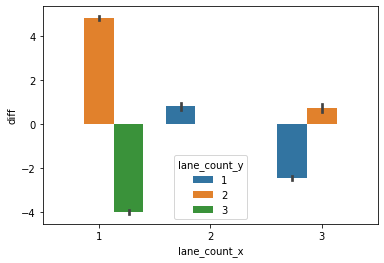

In [219]:
# diff. = 가는길 (x) - 오는길 (y)
# diff가 양수인건 가는길이 속도가 더빠름 오는길이 느림
#가는길이 lane이 1개이고 오는길 lane이 3개 인 것의 속도가 오는길 (y)가 빠른경우가 많고 
#가는길이 lane이 1개이고 오는길 lane이 2개 인 것의 속도가 오는길 (y)가 느린경우가 많다.
sns.barplot(data=lane_df, x = "lane_count_x", y ="diff",hue = "lane_count_y")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='diff'>

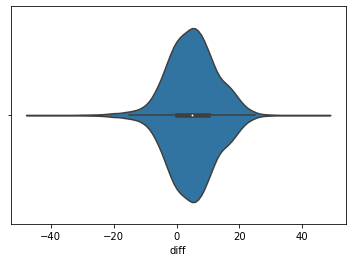

In [201]:
sns.violinplot(lane_df.query("lane_count_x == 1 & lane_count_y ==2")["diff"])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='diff'>

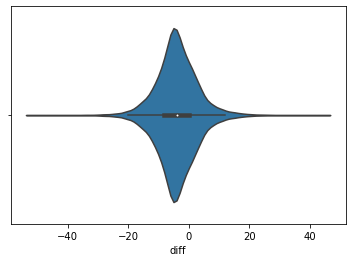

In [200]:
sns.violinplot(lane_df.query("lane_count_x == 1 & lane_count_y ==3")["diff"])

In [203]:
#가는 길에 lane count 가 2개인 경우 오는길의 lane count 는 1개이다
onelane_index = lane_df.query("lane_count_x == 1 & lane_count_y ==3").index

#### 길 rating에 따라 속도차이를 보았다

In [245]:
lane_df.road_rating_x.unique()

array([103, 107, 106])

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


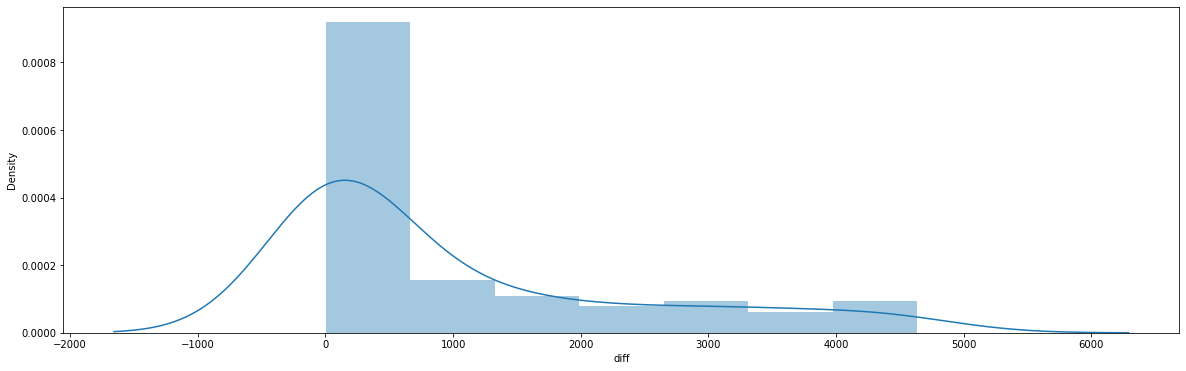

In [254]:
ax = plt.subplots(figsize=(20, 6))
ax = sns.distplot(lane_df.query("road_rating_x == 103")["diff"].value_counts())

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='diff', ylabel='Density'>

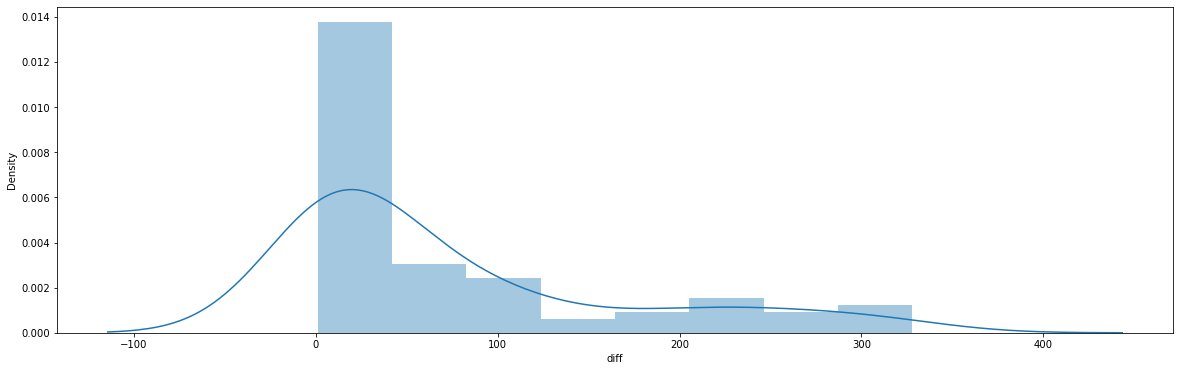

In [255]:
ax = plt.subplots(figsize=(20, 6))
ax = sns.distplot(lane_df.query("road_rating_x == 106")["diff"].value_counts())
ax

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


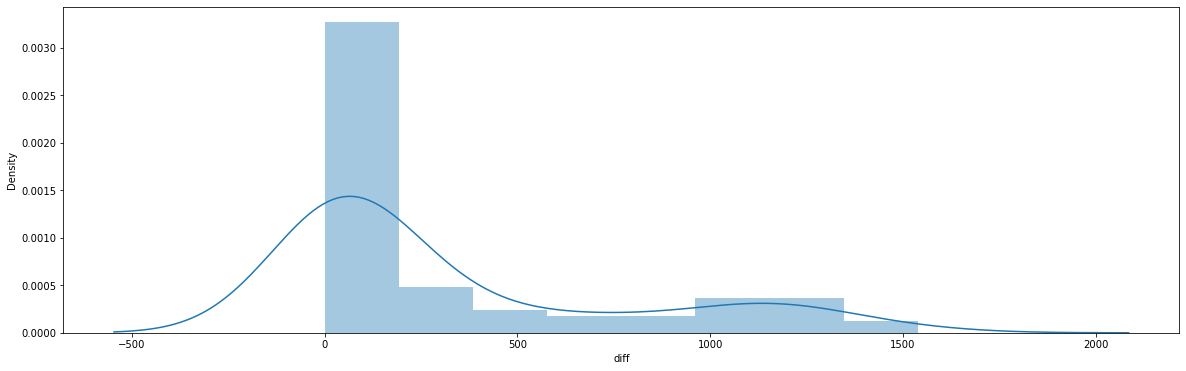

In [256]:
ax = plt.subplots(figsize=(20, 6))
ax = sns.distplot(lane_df.query("road_rating_x == 107")["diff"].value_counts())

In [300]:
#106번의 차이가 2155개
#road rating 106번이 오는길과 가는길에 

# print("103 x<y",pd.DataFrame(lane_df.query("road_rating_x==103")["diff"]).query("diff<0").shape[0])
print("x<y")
print(pd.DataFrame(lane_df.query("road_rating_x==103")["diff"]).query("diff<0").shape[0]/lane_df.query("road_rating_x==103").shape[0]*100)
print("x=y")
# print("103 x=y",pd.DataFrame(lane_df.query("road_rating_x==103")["diff"]).query("diff==0").shape[0])
print(pd.DataFrame(lane_df.query("road_rating_x==103")["diff"]).query("diff==0").shape[0]/lane_df.query("road_rating_x==103").shape[0]*100)
print("x>y")
# print("103 x>y",pd.DataFrame(lane_df.query("road_rating_x==103")["diff"]).query("diff>0").shape[0])
print(pd.DataFrame(lane_df.query("road_rating_x==103")["diff"]).query("diff>0").shape[0]/lane_df.query("road_rating_x==103").shape[0]*100)


print("_____________________________")

# print("106 x<y",pd.DataFrame(lane_df.query("road_rating_x==106")["diff"]).query("diff<0").shape[0])
print("x<y")
print(pd.DataFrame(lane_df.query("road_rating_x==106")["diff"]).query("diff<0").shape[0]/lane_df.query("road_rating_x==106").shape[0]*100)
# print("106 x=y",pd.DataFrame(lane_df.query("road_rating_x==106")["diff"]).query("diff==0").shape[0])
print("x=y")
print(pd.DataFrame(lane_df.query("road_rating_x==106")["diff"]).query("diff==0").shape[0]/lane_df.query("road_rating_x==106").shape[0]*100)
# print("106 x>y",pd.DataFrame(lane_df.query("road_rating_x==106")["diff"]).query("diff>0").shape[0])
print("x>y")
print(pd.DataFrame(lane_df.query("road_rating_x==106")["diff"]).query("diff>0").shape[0]/lane_df.query("road_rating_x==106").shape[0]*100)
print("_____________________________")
print("x<y")
# print("107 x<y",pd.DataFrame(lane_df.query("road_rating_x==107")["diff"]).query("diff<0").shape[0])
print(pd.DataFrame(lane_df.query("road_rating_x==107")["diff"]).query("diff<0").shape[0]/lane_df.query("road_rating_x==107").shape[0]*100)
# print("107 x=y",pd.DataFrame(lane_df.query("road_rating_x==107")["diff"]).query("diff==0").shape[0])
print("x=y")
print(pd.DataFrame(lane_df.query("road_rating_x==107")["diff"]).query("diff==0").shape[0]/lane_df.query("road_rating_x==107").shape[0]*100)
# print("107 x>y",pd.DataFrame(lane_df.query("road_rating_x==107")["diff"]).query("diff>0").shape[0])
print("x>y")
print(pd.DataFrame(lane_df.query("road_rating_x==107")["diff"]).query("diff>0").shape[0]/lane_df.query("road_rating_x==107").shape[0]*100)

x<y
47.9354547135315
x=y
4.677581708745044
x>y
47.38696357772345
_____________________________
x<y
66.2453656892484
x=y
3.8254128749578697
x>y
29.92922143579373
_____________________________
x<y
46.47486113089304
x=y
3.8171200683663296
x>y
49.70801880074063


### 106번 도로와 새벽,밤시간대
??새벽에 질주인가

106번 도로는 가는길과 오는길의 차이가 나는 경우가 그나마 있음
그것도 새벽시간에..

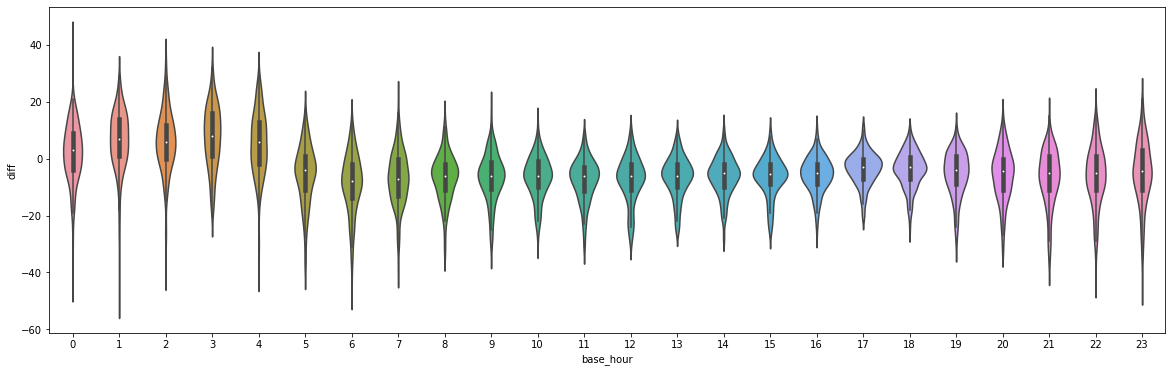

In [303]:
#시간으로 따지고 보면 점심 오후대에는 차이가 크지않다
#하지만 새벽 늦은 밤시간대에 차이가 심하다.
ax = plt.subplots(figsize=(20, 6))
ax = sns.violinplot(data=lane_df.query("road_rating_x==106"), x = "base_hour", y ="diff")

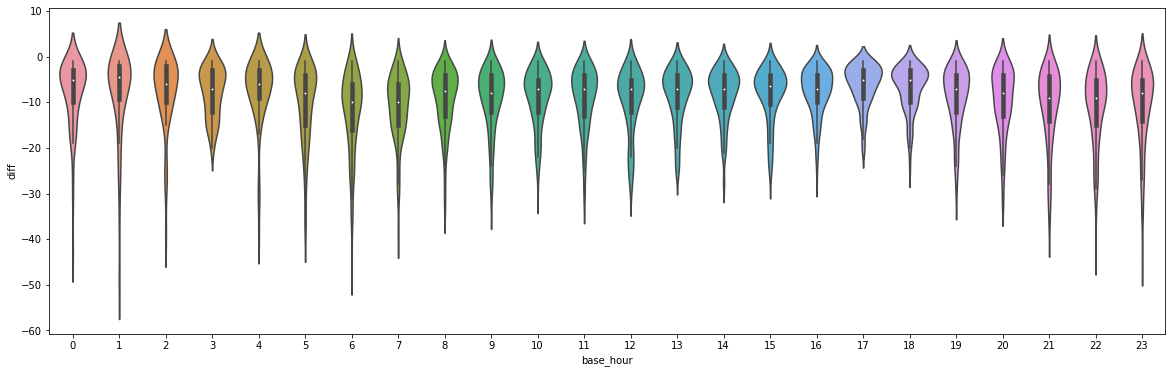

In [301]:
#가는길 x가 오는길 y보다 느린경우
#시간이 문제가되나?? 새벽시간이 많이 그렇다
ax = plt.subplots(figsize=(20, 6))
ax = sns.violinplot(data=lane_df.query("road_rating_x==106 & diff <0"), x = "base_hour", y ="diff")

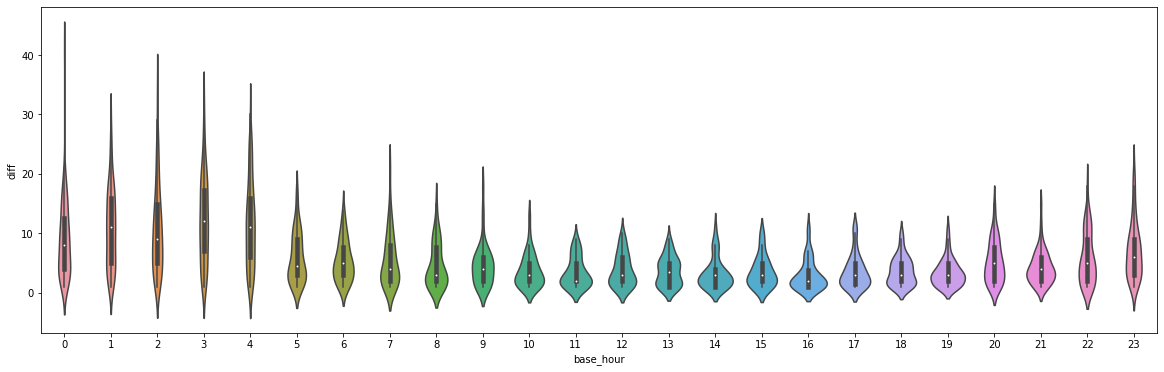

In [302]:
ax = plt.subplots(figsize=(20, 6))
ax = sns.violinplot(data=lane_df.query("road_rating_x==106 & diff >0"), x = "base_hour", y ="diff")

#### road_type

In [64]:
ease = pd.merge(positive[['id','base_date', 'base_hour', 'edge_label','target','road_type']], 
                 negative[['id','base_date', 'base_hour', 'edge_label','target','road_type']], on=['base_date', 'base_hour', 'edge_label'])

In [71]:
ease.query("road_type_x==3")

,id_x,base_date,base_hour,edge_label,target_x,road_type_x,id_y,target_y,road_type_y
24,TRAIN_0000033,20220522,22,33,26.0,3,TRAIN_4534864,33.0,3
36,TRAIN_0000052,20220608,13,50,20.0,3,TRAIN_0838093,20.0,3
91,TRAIN_0000124,20220322,20,115,45.0,3,TRAIN_0382504,49.0,3
100,TRAIN_0000139,20210902,21,129,18.0,3,TRAIN_3631539,28.0,3
121,TRAIN_0000172,20220328,20,152,33.0,3,TRAIN_1841031,50.0,3
...,...,...,...,...,...,...,...,...,...
1842593,TRAIN_4701069,20220219,13,115,42.0,3,TRAIN_2715995,53.0,3
1842622,TRAIN_4701141,20211031,7,449,44.0,3,TRAIN_2285631,48.0,3
1842635,TRAIN_4701170,20210902,19,542,17.0,3,TRAIN_4643469,41.0,3
1842640,TRAIN_4701187,20220115,14,227,45.0,3,TRAIN_3070879,45.0,3


#### target difference

### FeatureGeneration
#### 1) edge label 별 target mean

In [63]:
mean_df = train.groupby('edge_label')['target'].agg('mean')
display(mean_df)
train['edge_label_mean'] = train['edge_label'].map(mean_df)
test['edge_label_mean'] = test['edge_label'].map(mean_df)
train.head()

edge_label
-771    35.171046
-761    40.670277
-759    36.642698
-730    30.532535
-728    30.579674
          ...    
 730    18.315297
 761    43.255008
 763    69.019854
 771    34.097366
 784    32.622312
Name: target, Length: 808, dtype: float64

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,start_node_label,end_node_label,edge_label,edge_label_mean
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,없음,제3교래교,33.427749,126.662335,없음,52.0,0,0,0,49.511422
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,있음,KAL사거리,33.504811,126.526240,없음,30.0,1,306,1,26.400712
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,없음,상창육교,33.280072,126.362147,없음,61.0,2,107,2,59.101720
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,없음,서현주택,33.245565,126.566228,없음,20.0,3,33,3,25.024923
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,없음,애월입구,33.462677,126.330152,없음,38.0,4,459,4,39.873670


In [89]:
train.isna().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
start_node_label         0
end_node_label           0
edge_label               0
edge_label_mean          0
dtype: int64

In [90]:
test.isna().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
start_node_label         0
end_node_label           0
edge_label               0
edge_label_mean          0
dtype: int64

#### 1-2) edge label 별 평균 차량 속력

In [121]:
train.groupby(["edge_label","base_date"])["target"].mean()

edge_label  base_date
-771        20211201     33.958333
            20211202     34.875000
            20211203     35.272727
            20211204     35.208333
            20211205     34.958333
                           ...    
 784        20220522     33.166667
            20220523     35.000000
            20220524     29.090909
            20220525     30.214286
            20220526     27.000000
Name: target, Length: 210557, dtype: float64

#### 2) edge별 하루평균 이동차량수

In [97]:
display(train.query("edge_label == 771")[["end_node_name","start_node_name"]])
display(train.query("edge_label == -771")[["end_node_name","start_node_name"]])

,end_node_name,start_node_name
3048,애상로271,더럭초교차로
3436,애상로271,더럭초교차로
5171,애상로271,더럭초교차로
9090,애상로271,더럭초교차로
15001,애상로271,더럭초교차로
...,...,...
4692319,애상로271,더럭초교차로
4693134,애상로271,더럭초교차로
4695797,애상로271,더럭초교차로
4697352,애상로271,더럭초교차로


,end_node_name,start_node_name
4764,더럭초교차로,애상로271
6310,더럭초교차로,애상로271
6939,더럭초교차로,애상로271
8514,더럭초교차로,애상로271
9178,더럭초교차로,애상로271
...,...,...
4698825,더럭초교차로,애상로271
4699034,더럭초교차로,애상로271
4699222,더럭초교차로,애상로271
4699246,더럭초교차로,애상로271


In [96]:
train.query("edge_label == -771")[["end_node_name","start_node_name"]]

,end_node_name,start_node_name
4764,더럭초교차로,애상로271
6310,더럭초교차로,애상로271
6939,더럭초교차로,애상로271
8514,더럭초교차로,애상로271
9178,더럭초교차로,애상로271
...,...,...
4698825,더럭초교차로,애상로271
4699034,더럭초교차로,애상로271
4699222,더럭초교차로,애상로271
4699246,더럭초교차로,애상로271


In [117]:
temp_df = (train.groupby(["edge_label","base_date"])["id"].count()).reset_index().rename(columns = {"id" : 'car_by_day'})
train = train.merge(temp_df,how='left')
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,start_node_label,end_node_label,edge_label,edge_label_mean,car_by_day
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,제3교래교,33.427749,126.662335,없음,52.0,0,0,0,49.511422,43
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,KAL사거리,33.504811,126.526240,없음,30.0,1,306,1,26.400712,19
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,상창육교,33.280072,126.362147,없음,61.0,2,107,2,59.101720,23
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,서현주택,33.245565,126.566228,없음,20.0,3,33,3,25.024923,17
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,애월입구,33.462677,126.330152,없음,38.0,4,459,4,39.873670,24


In [119]:
temp_df = (test.groupby(["edge_label","base_date"])["id"].count()).reset_index().rename(columns = {"id" : 'car_by_day'})
test = test.merge(temp_df,how='left')
test.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,start_node_label,end_node_label,edge_label,edge_label_mean,car_by_day
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,없음,제주은행사거리,33.500772,126.543837,있음,412,265,-334,33.623164,24
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,없음,관광단지입구,33.258119,126.415840,없음,221,145,268,48.359276,24
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,없음,도순2교,33.259206,126.474687,없음,254,263,316,59.993453,23
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,없음,인다마을,33.471061,126.545467,없음,54,37,-38,33.185444,24
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,없음,봉개교 시종점,33.496863,126.581230,없음,245,312,656,46.299654,24


In [120]:
print(train.isna().sum())
print(test.isna().sum())

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
start_node_label         0
end_node_label           0
edge_label               0
edge_label_mean          0
car_by_day               0
dtype: int64
id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code   

- IDEA 1)multi_linked<br>
  해당 변수는 중용구간 여부를 나타낸 것으로 0이면 하나의 노선으로만 이루어져있으며 1이면 중용구간, 2개 이상의 노선으로 이루어졌다는 의미이다.<br>
  0이라고 직선거리는 아님에 유의해라.

In [101]:
train.groupby("edge_label")["id"].count()

edge_label
-771    3730
-761    2493
-759    2239
-730    4595
-728    5146
        ... 
 730    5341
 761    2396
 763    3828
 771    3759
 784     744
Name: id, Length: 808, dtype: int64

In [8]:
pd.Series([1,-1,-2,3]).abs()

0    1
1    1
2    2
3    3
dtype: int64

- IDEA 2)target<br>
target이 10미만인 데이터들이 꽤 있다. 길이 등을 구하여 이유를 탐색해야 한다.

In [3]:
train.target.value_counts().sort_index().iloc[:30]

1.0        46
2.0       175
3.0       323
4.0       659
5.0      1408
6.0      2501
7.0      3882
8.0      5214
9.0      7422
10.0    11160
11.0    13450
12.0    18785
13.0    21404
14.0    25296
15.0    30835
16.0    36795
17.0    44593
18.0    50892
19.0    55225
20.0    59976
21.0    64083
22.0    67297
23.0    71171
24.0    74098
25.0    76958
26.0    79442
27.0    82594
28.0    87514
29.0    92749
30.0    95679
Name: target, dtype: int64

In [3]:
low = train.query('target <= 10')

In [6]:
low

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
38,TRAIN_0000038,20220610,금,8,2,107,삼무로,0,0,50.0,...,0,제주일보사거리,33.490078,126.486558,있음,삼무공원사거리,33.489940,126.490153,없음,10.0
212,TRAIN_0000212,20211231,금,18,1,107,중정로,0,0,50.0,...,0,BYC,33.248491,126.566092,있음,정방수퍼,33.248633,126.567766,없음,9.0
333,TRAIN_0000333,20220104,화,12,3,103,일반국도12호선,0,0,70.0,...,0,중앙교,33.254129,126.565481,없음,중앙로타리,33.253200,126.561049,없음,7.0
538,TRAIN_0000538,20220527,금,21,2,107,새서귀로,0,0,60.0,...,0,삼주연립101동,33.251045,126.510574,없음,한솔고기국수,33.251947,126.510894,없음,10.0
796,TRAIN_0000796,20210903,금,21,2,107,경찰로,0,0,60.0,...,0,신성교회,33.253074,126.506393,없음,서호2차현대맨션203동,33.252183,126.506069,없음,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4700630,TRAIN_4700630,20211220,월,14,3,103,일반국도11호선,0,0,70.0,...,0,중앙여고사거리,33.487633,126.540414,있음,중앙여고입구,33.489161,126.539000,있음,10.0
4700632,TRAIN_4700632,20220526,목,9,2,107,동홍로,0,0,50.0,...,0,대흥개발(주),33.256517,126.568198,없음,동홍사거리,33.254628,126.567678,없음,9.0
4700648,TRAIN_4700648,20220517,화,2,2,107,동홍로,0,0,50.0,...,0,성카인테리어,33.257474,126.568494,없음,대흥개발(주),33.256517,126.568198,없음,10.0
4700829,TRAIN_4700829,20210919,일,14,3,103,일반국도16호선,0,0,70.0,...,0,노형파출소,33.486327,126.480150,없음,노형오거리,33.486000,126.479550,없음,9.0


In [7]:
low['harversine'] = [haversine((LAT1,LONG1),(LAT2,LONG2), unit='m') 
                     for _,LAT1,LONG1,LAT2,LONG2 in low[['start_latitude','start_longitude','end_latitude','end_longitude']].itertuples()]

C:\Users\ha\AppData\Local\Temp\ipykernel_5888\74909798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low['harversine'] = [haversine((LAT1,LONG1),(LAT2,LONG2), unit='m')


<AxesSubplot:>

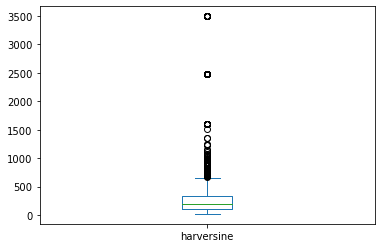

In [11]:
# 작은 값들로 구성된 것도 아닌데 왜....저런 숫자가 나오지?
low['harversine'].plot.box()

In [12]:
pd.crosstab(train.start_turn_restricted, train.end_turn_restricted)

end_turn_restricted,없음,있음
start_turn_restricted,,
없음,3992191,247510
있음,247408,214108


NameError: name 'plt' is not defined

C:\Users\ha\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50630 (\N{HANGUL SYLLABLE EOBS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ha\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ha\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51080 (\N{HANGUL SYLLABLE ISS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


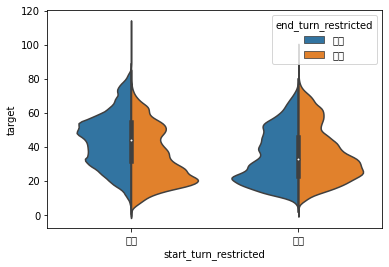

In [13]:
sns.violinplot(data=train, x='start_turn_restricted', y='target', hue='end_turn_restricted', split=True)

In [5]:
low

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
38,TRAIN_0000038,20220610,금,8,2,107,삼무로,0,0,50.0,...,0,제주일보사거리,33.490078,126.486558,있음,삼무공원사거리,33.489940,126.490153,없음,10.0
212,TRAIN_0000212,20211231,금,18,1,107,중정로,0,0,50.0,...,0,BYC,33.248491,126.566092,있음,정방수퍼,33.248633,126.567766,없음,9.0
333,TRAIN_0000333,20220104,화,12,3,103,일반국도12호선,0,0,70.0,...,0,중앙교,33.254129,126.565481,없음,중앙로타리,33.253200,126.561049,없음,7.0
538,TRAIN_0000538,20220527,금,21,2,107,새서귀로,0,0,60.0,...,0,삼주연립101동,33.251045,126.510574,없음,한솔고기국수,33.251947,126.510894,없음,10.0
796,TRAIN_0000796,20210903,금,21,2,107,경찰로,0,0,60.0,...,0,신성교회,33.253074,126.506393,없음,서호2차현대맨션203동,33.252183,126.506069,없음,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4700630,TRAIN_4700630,20211220,월,14,3,103,일반국도11호선,0,0,70.0,...,0,중앙여고사거리,33.487633,126.540414,있음,중앙여고입구,33.489161,126.539000,있음,10.0
4700632,TRAIN_4700632,20220526,목,9,2,107,동홍로,0,0,50.0,...,0,대흥개발(주),33.256517,126.568198,없음,동홍사거리,33.254628,126.567678,없음,9.0
4700648,TRAIN_4700648,20220517,화,2,2,107,동홍로,0,0,50.0,...,0,성카인테리어,33.257474,126.568494,없음,대흥개발(주),33.256517,126.568198,없음,10.0
4700829,TRAIN_4700829,20210919,일,14,3,103,일반국도16호선,0,0,70.0,...,0,노형파출소,33.486327,126.480150,없음,노형오거리,33.486000,126.479550,없음,9.0


In [3]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [17]:
train.drop_duplicates(['road_name','road_rating']).road_rating.value_counts()

107    41
106    15
103     6
Name: road_rating, dtype: int64

In [23]:
train.groupby(['road_name','road_rating'])['target'].size().sort_values().iloc[-10:]

road_name  road_rating
지방도97호선    106             106113
지방도1112호선  106             108777
태평로        107             129117
중산간서로      106             136629
지방도1132호선  106             179200
일반국도11호선   103             215701
일반국도95호선   103             248181
일반국도16호선   103             554510
-          107             569463
일반국도12호선   103            1046092
Name: target, dtype: int64

In [26]:
train['not_'] = train.road_name.apply(lambda x: 1 if x=='-' else 0)

In [32]:
train.query('road_name != "-"').groupby('road_name')[['start_latitude','start_longitude']].agg(lambda x: x.diff().min()).mean()

start_latitude    -0.040426
start_longitude   -0.044480
dtype: float64

In [33]:
train.query('road_name != "-"').groupby('road_name')[['end_latitude','end_longitude']].agg(lambda x: x.diff().min()).mean()

end_latitude    -0.040459
end_longitude   -0.044479
dtype: float64

In [ ]:
# 위의 값으로 제한을 두고 그중 가장 가까운 값으로 채운다!

<AxesSubplot:xlabel='start_latitude', ylabel='start_longitude'>

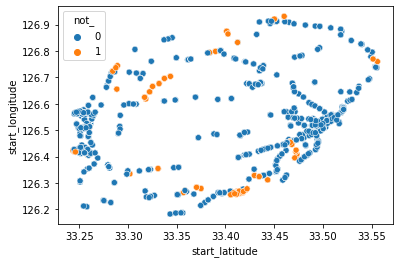

In [27]:
sns.scatterplot(data=train, x='start_latitude',y='start_longitude',hue='not_')

In [ ]:
# node_name 종류로 label 붙이기
# node name으로 label 붙이기
# node 조합 라벨링, 라벨들을 역으로 갖는 데이터는 음수 라벨링

In [21]:
test.road_name.value_counts()

일반국도12호선     50140
일반국도16호선     42961
지방도1132호선    20585
일반국도11호선     16145
태평로          15554
-            12600
경찰로          10045
새서귀로         10038
동홍로           9688
번영로           8876
지방도1115호선     8529
연삼로           7395
중문로           7045
일반국도99호선      5587
권학로           5264
시민광장로         4576
시청로           4518
산서로           4277
중정로           4119
서사로           2864
지방도1118호선     2856
중앙로           2853
관광단지로         2817
제2거로교         1480
첨단로           1478
애조로           1477
연북2교          1473
동부관광도로        1473
연동로           1471
연북로           1469
고평교           1468
한천로           1464
신대로           1463
관덕로           1454
지방도1136호선     1454
어시천교          1445
외도천교          1445
삼성로           1435
신산로           1420
삼봉로           1357
관광단지1로        1348
동문로           1330
수영장길          1327
관광단지2로        1319
지방도1117호선     1104
지방도97호선        755
Name: road_name, dtype: int64

<AxesSubplot:xlabel='start_latitude', ylabel='start_longitude'>

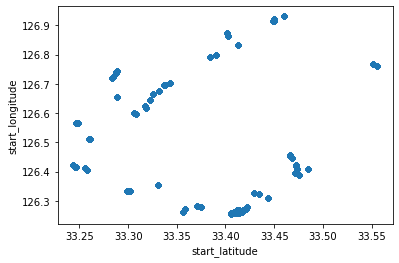

In [20]:
# 같은 도로로 보기 힘들다.
# clustering해서 label 넣는게 어떨지.
train.query('road_name == "-"').plot.scatter(x='start_latitude',y='start_longitude')

<AxesSubplot:xlabel='end_latitude', ylabel='end_longitude'>

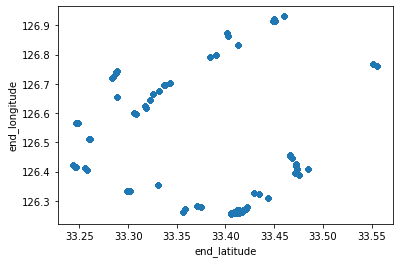

In [25]:
# 같은 도로로 보기 힘들다.
# clustering해서 label 넣는게 어떨지.
train.query('road_name == "-"').plot.scatter(x='end_latitude',y='end_longitude')

<AxesSubplot:xlabel='start_latitude', ylabel='start_longitude'>

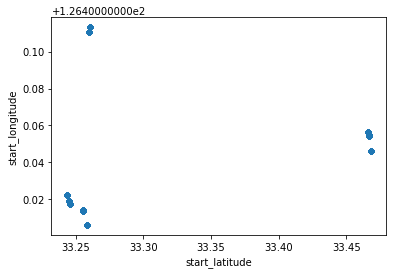

In [24]:
# 같은 도로로 보기 힘들다.
# clustering해서 label 넣는게 어떨지.
test.query('road_name == "-"').plot.scatter(x='start_latitude',y='start_longitude')

In [16]:
train.road_rating.value_counts(normalize=True)

103    0.459351
107    0.336554
106    0.204094
Name: road_rating, dtype: float64

In [6]:
train.connect_code.value_counts()

0      4689075
103      12142
Name: connect_code, dtype: int64

In [8]:
pd.crosstab(train.multi_linked, train.connect_code)

connect_code,0,103
multi_linked,,
0,4686836,12142
1,2239,0


In [14]:
train.query('target==1').shape

(46, 23)

In [17]:
train.query('target!=1').target.sort_values()

4183262      2.0
1132095      2.0
1763850      2.0
1226542      2.0
2674600      2.0
           ...  
4559340    103.0
242903     112.0
2607664    112.0
4386692    113.0
3841974    113.0
Name: target, Length: 4701171, dtype: float64

In [ ]:
train.target.plot.kde()

- IDEA 4) 시점에 따른 변화

In [19]:
train.target.value_counts().sort_index().iloc[:30]

1.0        46
2.0       175
3.0       323
4.0       659
5.0      1408
6.0      2501
7.0      3882
8.0      5214
9.0      7422
10.0    11160
11.0    13450
12.0    18785
13.0    21404
14.0    25296
15.0    30835
16.0    36795
17.0    44593
18.0    50892
19.0    55225
20.0    59976
21.0    64083
22.0    67297
23.0    71171
24.0    74098
25.0    76958
26.0    79442
27.0    82594
28.0    87514
29.0    92749
30.0    95679
Name: target, dtype: int64

In [13]:
train.target.sort_values().iloc[:30]

1040223    1.0
3903935    1.0
1165730    1.0
4016125    1.0
3282290    1.0
2834350    1.0
2863626    1.0
1130704    1.0
2654933    1.0
1817019    1.0
4218102    1.0
1586595    1.0
3535091    1.0
3777990    1.0
1323784    1.0
763638     1.0
1494269    1.0
1234545    1.0
3858989    1.0
1561363    1.0
1583846    1.0
2735995    1.0
2790314    1.0
87757      1.0
3850492    1.0
3035390    1.0
2431511    1.0
926662     1.0
278873     1.0
2038858    1.0
Name: target, dtype: float64

<AxesSubplot:>

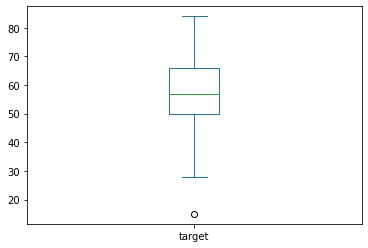

In [10]:
train.query('connect_code==103 & multi_linked==0').target.plot.box()

In [7]:
train.multi_linked.value_counts()

0    4698978
1       2239
Name: multi_linked, dtype: int64

In [ ]:
# 불필요한 열 제거
del train['vehicle_restricted'],train['height_restricted']
del test['vehicle_restricted'],test['height_restricted']

In [3]:
cluster_train = pd.read_csv('../data/clean/cluster_train.csv')
cluster_test = pd.read_csv('../data/clean/cluster_test.csv')

In [3]:
enforce_train = pd.read_csv('../data/clean/enforce_train.csv')
enforce_test = pd.read_csv('../data/clean/enforce_test.csv')

In [5]:
child_train = pd.read_csv('../data/clean/child_train.csv')
child_test = pd.read_csv('../data/clean/child_test.csv')

In [6]:
protect_train = pd.read_csv('../data/clean/protect_train.csv')
protect_test = pd.read_csv('../data/clean/protect_test.csv')

In [7]:
geometry_train = pd.read_parquet('../data/clean/geometry_train.parquet')[['id','length','speed','time']]
geometry_test = pd.read_parquet('../data/clean/geometry_test.parquet')[['id','length','speed','time']]